In [1]:
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import seaborn as sns

import sys
sys.path.insert(0,'/home/gsoc0/Adversarial_CapsNet_Pytorch/')
from model.net import *
from model.cnn_net import *
from utils.training import *
from data.data import *

## Experiment Config

In [2]:
model_path = os.path.join(os.getcwd(), "weights")

args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 512,
#     'N_EPOCHS': 100,
#     'LEARNING_RATE_1': 1e-2,
#     'LEARNING_RATE_2': 1e-2,
#     'WEIGHTDECAY':5e-6,
#     #Scheduler
#     'USE_SCHEDULER':True,
#     'sched_milestones':[14,25,30,40,50],
#     'sched_gamma':0.1,
    
#     #Loss Function
#     'LAMBDA_recon': 0.5,
#     'LAMBDA_class': 1,
    
    ##For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusR',
    
}

#Setting Default Cuda Device
torch.cuda.set_device(2)

## Model Loading

In [3]:
#Modified Reconstructor

class Reconstructor(nn.Module):
    def __init__(self, net, args):
        super(Reconstructor, self).__init__()
        self.args = args
        self.reconstraction_layers = net.decoder.reconstraction_layers
        self.mean = torch.tensor(0.1307)
        self.std = torch.tensor(0.3081)
        if(args['USE_CUDA']):
            self.mean = self.mean.cuda()
            self.std = self.std.cuda()
        self.unnormalize = UnNormalize(self.mean, self.std)
        
    def forward(self, x, data):
        with torch.no_grad():
            classes = torch.sqrt((x ** 2).sum(2))
            classes = F.softmax(classes.squeeze(), dim=1)
            _, max_length_indices = classes.max(dim=1)
            eye = torch.sparse.torch.eye(10)
            if USE_CUDA:
                eye = eye.cuda()
            reconstructions_of_digits = []
            list_of_indices = [max_length_indices]
            for i, index_list in enumerate(list_of_indices):
                masked = eye.index_select(dim=0, index=index_list.squeeze().data)
                reconstructions_of_digits.append(self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), 1, -1)))

            reconstructions_of_digits = torch.cat(reconstructions_of_digits, dim=1) 
            expanded_data = data.view(x.size(0), 1, -1).expand(-1, len(list_of_indices), -1)
            unnormalized_data = self.unnormalize(expanded_data)
            l2_distances = torch.square((unnormalized_data - reconstructions_of_digits)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
            return l2_distances
    
    def class_conditional_recon(self, x, data):
        with torch.no_grad():
            classes = torch.sqrt((x ** 2).sum(2))
            classes = F.softmax(classes.squeeze(), dim=1)
            _, max_length_indices = classes.max(dim=1)
            eye = torch.sparse.torch.eye(10)
            if USE_CUDA:
                eye = eye.cuda()
            reconstructions_of_digits = []
            list_of_indices = [max_length_indices]
            for i, index_list in enumerate(list_of_indices):
                masked = eye.index_select(dim=0, index=index_list.squeeze().data)
                reconstructions_of_digits.append(self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), 1, -1)))

            reconstructions_of_digits = torch.cat(reconstructions_of_digits, dim=1)
            expanded_data = data.view(x.size(0), 1, -1).expand(-1, len(list_of_indices), -1)
            unnormalized_data = self.unnormalize(expanded_data)
            l2_distances = torch.square((unnormalized_data - reconstructions_of_digits)).sum(dim=(list(range(0, len(expanded_data.shape)))[2:]))
            return l2_distances
    
def imshow(img):
#     img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.cpu().numpy()
#     plt.imshow(np.transpose(npimg)#, (1, 2, 0)))
    plt.imshow(npimg)
    plt.show()

In [4]:
class Config:
    def __init__(self, dataset='mnist'):
        # CNN (cnn)
        self.cnn_in_channels = 1
        self.cnn_out_channels = 12
        self.cnn_kernel_size = 15

        # Primary Capsule (pc)
        self.pc_num_capsules = 1
        self.pc_in_channels = 12
        self.pc_out_channels = 16
        self.pc_kernel_size = 8
        self.pc_num_routes = 7 * 7

        # Digit Capsule 1 (dc)
        self.dc_num_capsules = 49
        self.dc_num_routes = 7 * 7
        self.dc_in_channels = 16
        self.dc_out_channels = 16 #1
        
        # Digit Capsule 2 (dc)
        self.dc_2_num_capsules = 10
        self.dc_2_num_routes = 7 * 7
        self.dc_2_in_channels = 16 #1
        self.dc_2_out_channels = 16

        # Decoder
        self.input_width = 28
        self.input_height = 28
torch.manual_seed(1)
config = Config()

net = CapsNet(args, config)
# capsule_net = torch.nn.DataParallel(capsule_net)
if args['USE_CUDA']:
    net = net.cuda()
    
net.load_state_dict(torch.load(os.path.join(model_path, 'CapsNet_mnist.pth'), map_location='cpu'))

<All keys matched successfully>

## Loading Dataset

In [5]:
trainloader, testloader = dataset(args)
for data in trainloader:
    print(data[0][0].min())
    print(data[0][0].max())
    break

tensor(-0.4242)
tensor(2.8215)


##  Untargeted WhiteBox Attack for CapsuleNet

In [6]:
a = torch.tensor([], dtype=torch.int16)
b = torch.tensor([1,2,3], dtype=torch.int16)
torch.cat((a,b))

tensor([1, 2, 3], dtype=torch.int16)

In [7]:
import matplotlib.pyplot as plt
from advertorch.attacks import LinfPGDAttack, GradientSignAttack, CarliniWagnerL2Attack, LinfBasicIterativeAttack

class Model_for_Adversary(nn.Module):
    def __init__(self, net):
        super(Model_for_Adversary, self).__init__()
        self.net = net
        
    def forward(self, x):
        output, recons, masked = self.net(x)
        classes = torch.sqrt((output ** 2).sum(2)).squeeze()
        return classes
    
def WhiteBox_Attacks_Targeted(net, dataloader, adversary_dict, args):
    net.eval()
    n_batch = len(dataloader)
    Success_Rate = {key:0.0 for key in adversary_dict.keys()}
    Undetected_Rate = {key:0.0 for key in adversary_dict.keys()}
    Und_l2 = {key:torch.tensor([],dtype=torch.int16).cuda() for key in adversary_dict.keys()}
    for adversary in adversary_dict.keys():
        for batch_id, (data, labels) in enumerate(tqdm(dataloader)):
            target = torch.randint(0,10,size=(labels.size(0),), dtype=labels.dtype).cuda()
            if(args['USE_CUDA']):
                data, labels = data.cuda(), labels.cuda()

            adv_data = adversary_dict[adversary].perturb(data, target)
            with torch.no_grad():
                output, reconstructions, max_length_indices = net(adv_data)
                unnormalized_data = net.decoder.unnormalize(adv_data)
                l2_distances = ((reconstructions.view(adv_data.size(0),-1)-unnormalized_data.view(adv_data.size(0), -1))**2).sum(1).squeeze().detach()
                theta = np.percentile(l2_distances.cpu().numpy(), 95)
                Und_l2[adversary] = torch.cat((Und_l2[adversary],l2_distances[max_length_indices == target]))
                Success_Rate[adversary]+=torch.sum(max_length_indices == target).item()
                Undetected_Rate[adversary]+=torch.sum(l2_distances[max_length_indices == target]<=theta).item()
        
        Und_l2[adversary] = Und_l2[adversary].cpu().numpy()
        Success_Rate[adversary]/=100
        Undetected_Rate[adversary]/=100
    return Success_Rate, Undetected_Rate, Und_l2

def WhiteBox_Attacks_Untargeted(net, dataloader, adversary_dict, args):
    net.eval()
    n_batch = len(dataloader)
    Success_Rate = {key:0.0 for key in adversary_dict.keys()}
    Undetected_Rate = {key:0.0 for key in adversary_dict.keys()}
    Und_l2 = {key:torch.tensor([],dtype=torch.int16).cuda() for key in adversary_dict.keys()}
    for adversary in adversary_dict.keys():
        for batch_id, (data, labels) in enumerate(tqdm(dataloader)):
            if(args['USE_CUDA']):
                data, labels = data.cuda(), labels.cuda()

            adv_data = adversary_dict[adversary].perturb(data)
            with torch.no_grad():
                output, reconstructions, max_length_indices = net(adv_data)
                unnormalized_data = net.decoder.unnormalize(adv_data)
                l2_distances = ((reconstructions.view(adv_data.size(0),-1)-unnormalized_data.view(adv_data.size(0), -1))**2).sum(1).squeeze().detach()
                theta = np.percentile(l2_distances.cpu().numpy(), 95)
                Und_l2[adversary] = torch.cat((Und_l2[adversary],l2_distances[max_length_indices != labels]))
                Success_Rate[adversary]+=torch.sum(max_length_indices != labels).item()
                Undetected_Rate[adversary]+=torch.sum(l2_distances[max_length_indices!=labels]<=theta).item()
#                 print(Success_Rate[adversary])
#                 print(Undetected_Rate[adversary])
#                 print(theta)
        Und_l2[adversary] = Und_l2[adversary].cpu().numpy() 
        Success_Rate[adversary]/=100
        Undetected_Rate[adversary]/=100
    return Success_Rate, Undetected_Rate, Und_l2

In [8]:
model_for_adversary = Model_for_Adversary(net)
    
adversary_dict = {}
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3,
    nb_iter=100, eps_iter=0.01, rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3, clip_min=-0.4242, clip_max=2.8215, targeted=False)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.05, nb_iter=100, eps_iter=0.01, clip_min=-0.4242, clip_max=2.8215, targeted=False)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

Success_Rate, Undetected_Rate, Und_L2 = WhiteBox_Attacks_Untargeted(net, testloader, adversary_dict, args)

100%|██████████| 20/20 [36:31<00:00, 109.55s/it]


(20,)
(8896,)
(20,)
(2598,)
(20,)
(161,)


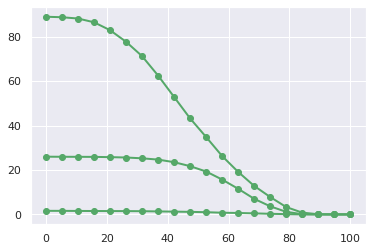

In [39]:

for adversary in adversary_dict.keys():
    x = np.linspace(0, 100, 20)
    y = np.array([np.sum(Und_L2[adversary]<=(1-(i_x/100))*(Und_L2[adversary].max())).item()/100 for i_x in x])
    print(y.shape)
    print(Und_L2[adversary].shape)
    plt.plot(x, y, 'go-', label='line1', linewidth=2)
# for i in x:
#     print(i)

In [8]:
print(Success_Rate)
print(Undetected_Rate)

{'PGD': 0.8828, 'FGSM': 0.2664, 'BIM': 0.02}
{'PGD': 0.8328, 'FGSM': 0.2223, 'BIM': 0.0128}


In [8]:
print(Success_Rate)
print(Undetected_Rate)

{'PGD': 0.9488, 'FGSM': 0.2664, 'BIM': 0.02}
{'PGD': 0.8984, 'FGSM': 0.2223, 'BIM': 0.0128}


In [10]:
print(Success_Rate)
print(Undetected_Rate)


{'PGD': 0.1409, 'FGSM': 0.2664, 'BIM': 0.02}
{'PGD': 0.1048, 'FGSM': 0.2223, 'BIM': 0.0128}


In [40]:
model_for_adversary = Model_for_Adversary(net)
    
adversary_dict = {}
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3,
    nb_iter=100, eps_iter=0.01, rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3, clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.05, nb_iter=100, eps_iter=0.01, clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

Success_Rate, Undetected_Rate, Und_L2 = WhiteBox_Attacks_Targeted(net, testloader, adversary_dict, args)

100%|██████████| 20/20 [36:28<00:00, 109.41s/it]


(20,)
(3874,)
(20,)
(1409,)
(20,)
(977,)


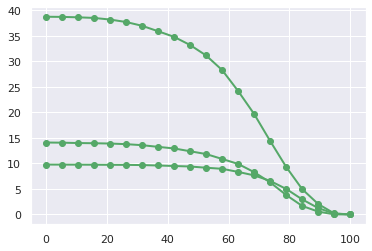

In [41]:

for adversary in adversary_dict.keys():
    x = np.linspace(0, 100, 20)
    y = np.array([np.sum(Und_L2[adversary]<=(1-(i_x/100))*(Und_L2[adversary].max())).item()/100 for i_x in x])
    print(y.shape)
    print(Und_L2[adversary].shape)
    plt.plot(x, y, 'go-', label='line1', linewidth=2)
# for i in x:
#     print(i)

In [8]:
print(Success_Rate)
print(Undetected_Rate)


{'PGD': 32.26, 'FGSM': 21.36, 'BIM': 0.99}
{'PGD': 27.19, 'FGSM': 17.13, 'BIM': 0.59}


## Histograms for CNN + CR

In [7]:
args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 256,
    'N_EPOCHS': 100,
    'LEARNING_RATE_1': 1e-2,
    'LEARNING_RATE_2': 1e-2,
    'WEIGHTDECAY':5e-6,
    
    #Scheduler
    'USE_SCHEDULER':True,
    'sched_milestones':[8,20,30,40,50],
    'sched_gamma':0.1,
    
    #Loss Function
    'LAMBDA_recon': 0.5,
    'LAMBDA_class': 1,
    
    #For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusCR',
    
}

In [8]:
class Config:
    def __init__(self, dataset='mnist'):
        # CONV1
        self.conv1_in = 1
        self.conv1_out = 12
        self.conv1_kernel_size = 15

        # CONV2
        self.conv2_in = 12
        self.conv2_out = 16
        self.conv2_kernel_size = 8

        # FC1
        self.fc1_in = 7 * 7 * 16
        self.fc1_out = 784
        
        # FC1
        self.fc2_in = 784
        self.fc2_out = 160

torch.manual_seed(2)
config = Config()

net = CNNnet(args, config)

# net = torch.nn.DataParallel(net)
net.load_state_dict(torch.load(os.path.join(model_path, 'CNNplusCR_mnist.pth'), map_location='cpu'))
    
if args['USE_CUDA']:
    net = net.cuda()
    

In [10]:
import matplotlib.pyplot as plt
from advertorch.attacks import LinfPGDAttack, GradientSignAttack, CarliniWagnerL2Attack, LinfBasicIterativeAttack

class Model_for_Adversary(nn.Module):
    def __init__(self, net):
        super(Model_for_Adversary, self).__init__()
        self.net = net
        
    def forward(self, x):
        output, recons, masked = self.net(x)
        classes = output.sum(2)
        return classes
    
def WhiteBox_Attacks_Targeted(net, dataloader, adversary_dict, args):
    net.eval()
    n_batch = len(dataloader)
    Success_Rate = {key:0.0 for key in adversary_dict.keys()}
    Undetected_Rate = {key:0.0 for key in adversary_dict.keys()}
    
    for adversary in adversary_dict.keys():
        for batch_id, (data, labels) in enumerate(tqdm(dataloader)):
            target = torch.randint(0,10,size=(labels.size(0),), dtype=labels.dtype).cuda()
            if(args['USE_CUDA']):
                data, labels = data.cuda(), labels.cuda()

            adv_data = adversary_dict[adversary].perturb(data, target)
            with torch.no_grad():
                output, reconstructions, max_length_indices = net(adv_data)
                unnormalized_data = net.decoder.unnormalize(adv_data)
                l2_distances = ((reconstructions.view(adv_data.size(0),-1)-unnormalized_data.view(adv_data.size(0), -1))**2).sum(1).squeeze().detach()
                theta = np.percentile(l2_distances.cpu().numpy(), 95)
                Success_Rate[adversary]+=torch.sum(max_length_indices != labels).item()
                Undetected_Rate[adversary]+=torch.sum(l2_distances[max_length_indices!=labels]<=theta).item()
        Success_Rate[adversary]/=100
        Undetected_Rate[adversary]/=100
    return Success_Rate, Undetected_Rate

def WhiteBox_Attacks_Untargeted(net, dataloader, adversary_dict, args):
    net.eval()
    n_batch = len(dataloader)
    Success_Rate = {key:0.0 for key in adversary_dict.keys()}
    Undetected_Rate = {key:0.0 for key in adversary_dict.keys()}
    
    for adversary in adversary_dict.keys():
        for batch_id, (data, labels) in enumerate(tqdm(dataloader)):
            if(args['USE_CUDA']):
                data, labels = data.cuda(), labels.cuda()

            adv_data = adversary_dict[adversary].perturb(data)
            with torch.no_grad():
                output, reconstructions, max_length_indices = net(adv_data)
                unnormalized_data = net.decoder.unnormalize(adv_data)
                l2_distances = ((reconstructions.view(adv_data.size(0),-1)-unnormalized_data.view(adv_data.size(0), -1))**2).sum(1).squeeze().detach()
                theta = np.percentile(l2_distances.cpu().numpy(), 95)
                Success_Rate[adversary]+=torch.sum(max_length_indices != labels).item()
                Undetected_Rate[adversary]+=torch.sum(l2_distances[max_length_indices!=labels]<=theta).item()
#                 print(Success_Rate[adversary])
#                 print(Undetected_Rate[adversary])
#                 print(theta)
        Success_Rate[adversary]/=100
        Undetected_Rate[adversary]/=100
    return Success_Rate, Undetected_Rate    


In [11]:
model_for_adversary = Model_for_Adversary(net)
    
adversary_dict = {}
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3,
    nb_iter=100, eps_iter=0.01, rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3, clip_min=-0.4242, clip_max=2.8215, targeted=False)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.05, nb_iter=100, eps_iter=0.01, clip_min=-0.4242, clip_max=2.8215, targeted=False)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

Success_Rate, Undetected_Rate = WhiteBox_Attacks_Untargeted(net, testloader, adversary_dict, args)

100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


In [12]:
print(Success_Rate)
print(Undetected_Rate)


{'PGD': 73.67, 'FGSM': 31.25, 'BIM': 9.51}
{'PGD': 68.88, 'FGSM': 27.77, 'BIM': 7.53}


In [13]:
model_for_adversary = Model_for_Adversary(net)
    
adversary_dict = {}
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3,
    nb_iter=100, eps_iter=0.01, rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3, clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.05, nb_iter=100, eps_iter=0.01, clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

Success_Rate, Undetected_Rate = WhiteBox_Attacks_Targeted(net, testloader, adversary_dict, args)

100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


In [14]:
print(Success_Rate)
print(Undetected_Rate)


{'PGD': 54.23, 'FGSM': 28.09, 'BIM': 5.18}
{'PGD': 49.86, 'FGSM': 24.99, 'BIM': 4.01}


## Histograms for CNN plus R

In [13]:
args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 256,
    'N_EPOCHS': 100,
    'LEARNING_RATE_1': 1e-2,
    'LEARNING_RATE_2': 1e-2,
    'WEIGHTDECAY':5e-6,
    
    #Scheduler
    'USE_SCHEDULER':True,
    'sched_milestones':[8,20,30,40,50],
    'sched_gamma':0.1,
    
    #Loss Function
    'LAMBDA_recon': 0.5,
    'LAMBDA_class': 1,
    
    #For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusR',
    
}

In [14]:
class Config:
    def __init__(self, dataset='mnist'):
        # CONV1
        self.conv1_in = 1
        self.conv1_out = 12
        self.conv1_kernel_size = 15

        # CONV2
        self.conv2_in = 12
        self.conv2_out = 16
        self.conv2_kernel_size = 8

        # FC1
        self.fc1_in = 7 * 7 * 16
        self.fc1_out = 784
        
        # FC1
        self.fc2_in = 784
        self.fc2_out = 160

torch.manual_seed(2)
config = Config()

net = CNNnet(args, config)

# net = torch.nn.DataParallel(net)
net.load_state_dict(torch.load(os.path.join(model_path, 'CNNplusR_mnist.pth'), map_location='cpu'))
    
if args['USE_CUDA']:
    net = net.cuda()
    

In [16]:
recon = Reconstructor(net, args)
model_for_adversary = Model_for_Adversary(net)
    
adversary = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.3,
    nb_iter=1000, eps_iter=0.01, rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

l2_distances = L2_Distances(net, recon, testloader, adversary, args)

100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


(0, 200)

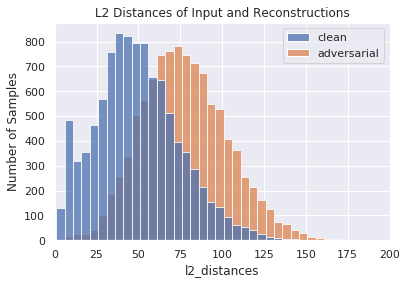

In [19]:
clean_l2 = l2_distances[0]#[list(range(0,20000,2))]
adversarial_l2 = l2_distances[1]#[list(range(1,19999,2))]

fig, ax = plt.subplots()
sns.set_theme()
sns.histplot({'clean':clean_l2, 'adversarial':adversarial_l2}, bins=range(1, 200, 5), ax=ax, kde=False)
ax.set_xlabel('l2_distances')
ax.set_ylabel('Number of Samples')
ax.set_title('L2 Distances of Input and Reconstructions')
ax.set_xlim([0, 200])